# BIOL 487/SYDE 552 Computational Neuroscience Final Project

#### Sephora Mathivathanan
#### stmathiv@uwaterloo.ca
#### 20901200


Baseline Model

In [148]:
import os
import cv2
import numpy
import numpy as np
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

In [149]:
class CKDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = sorted([
            d for d in os.listdir(data_dir)
            if os.path.isdir(os.path.join(data_dir, d)) and not d.startswith('.')
        ])

        for label, emotion in enumerate(self.classes):
            emotion_path = os.path.join(data_dir, emotion)
            for fname in os.listdir(emotion_path):
                fpath = os.path.join(emotion_path, fname)
                img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, (48, 48))
                self.images.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [150]:
print("Inside archive-2:", os.listdir('archive-2'))
print("Inside archive-2/CK+48:", os.listdir('archive-2/CK+48'))

Inside archive-2: ['CK+48', '.ipynb_checkpoints']
Inside archive-2/CK+48: ['happy', 'contempt', 'fear', 'surprise', 'sadness', 'anger', '.ipynb_checkpoints', 'disgust']


In [151]:
transform = transforms.Compose([
    transforms.ToTensor(),                 
    transforms.Normalize((0.5,), (0.5,))     
])

data_root    = 'archive-2/CK+48'            
full_dataset = CKDataset(data_dir=data_root, transform=transform)

print(f"Found {len(full_dataset.classes)} emotion classes:", full_dataset.classes)
print(f"Total images loaded: {len(full_dataset)}")

Found 7 emotion classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
Total images loaded: 910


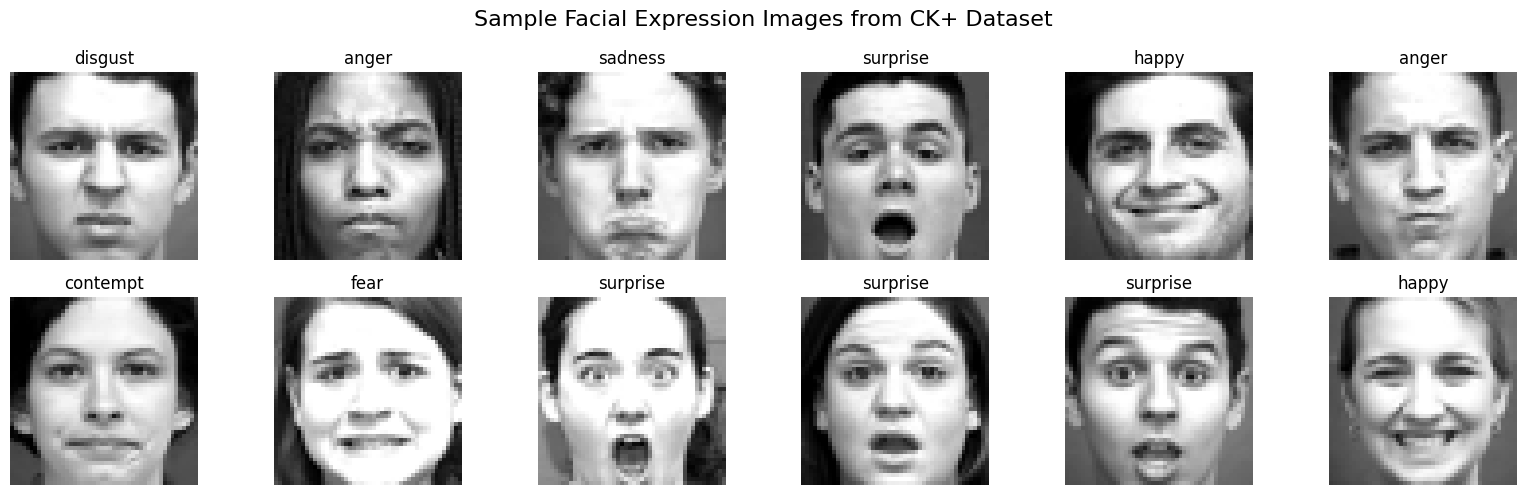

In [153]:
emotion_labels = full_dataset.classes 

plt.figure(figsize=(16, 5))  
for i in range(12):
    idx = np.random.randint(0, len(full_dataset))
    img, label = full_dataset[idx]
    img_np = img.squeeze().numpy()

    plt.subplot(2, 6, i + 1)  
    plt.imshow(img_np, cmap='gray')
    plt.title(f"{emotion_labels[label]}")
    plt.axis('off')

plt.suptitle("Sample Facial Expression Images from CK+ Dataset", fontsize=16)
plt.tight_layout()
plt.show()

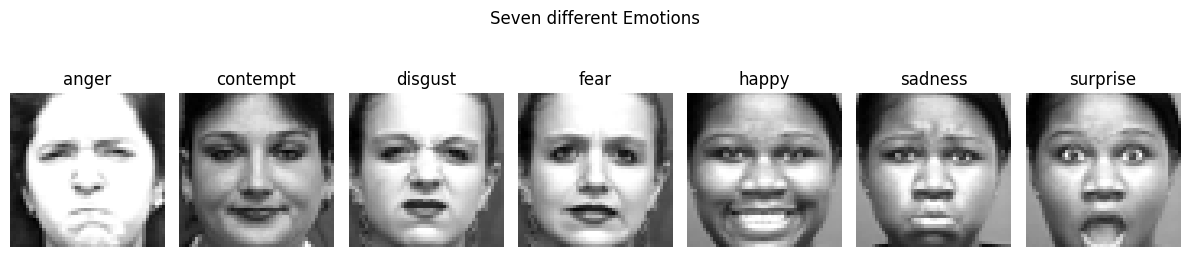

In [154]:
emotion_labels = full_dataset.classes
shown_classes = set()
plt.figure(figsize=(12, 3))  

i = 0
for idx in range(len(full_dataset)):
    img, label = full_dataset[idx]
    emotion = emotion_labels[label]
    
    if emotion not in shown_classes:
        shown_classes.add(emotion)
        img_np = img.squeeze().numpy()

        plt.subplot(1, 7, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(emotion)
        plt.axis('off')
        
        i += 1

    if len(shown_classes) == 7:
        break

plt.suptitle("Seven different Emotions", fontsize=12)
plt.tight_layout()
plt.show()

In [156]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size
train_ds, test_ds = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

print(f"Train / Test split: {len(train_ds)} / {len(test_ds)} samples")

Train / Test split: 728 / 182 samples


In [157]:
class base(nn.Module):
    def __init__(self, hidden_units, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(48*48, hidden_units)
        self.dropout = nn.Dropout(0.5)
        self.fc2     = nn.Linear(hidden_units, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))  
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [172]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(full_dataset.classes)
hidden_sizes = [16, 32, 64, 128]
accuracies = []

def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return correct / total

for h in hidden_sizes:

    print(f"\n Training with {h} neurons ")
    model = base(hidden_units=h, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

    val_acc = evaluate(model, test_loader)
    accuracies.append(val_acc)
    print(f"Validation Accuracy: {val_acc*100:.2f}%")


 Training with 16 neurons 
Validation Accuracy: 32.97%

 Training with 32 neurons 
Validation Accuracy: 34.62%

 Training with 64 neurons 
Validation Accuracy: 55.49%

 Training with 128 neurons 
Validation Accuracy: 32.97%


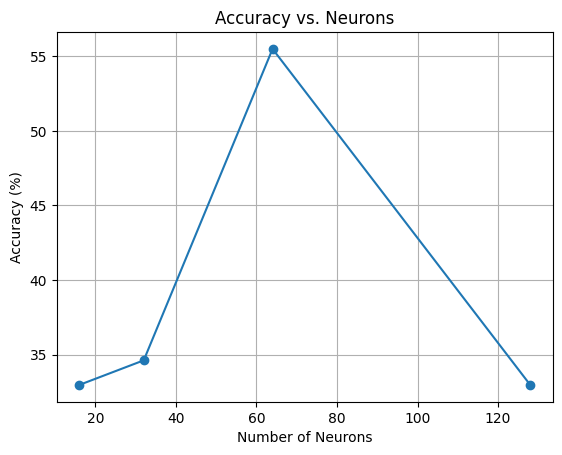

In [217]:
plt.plot(hidden_sizes, [a*100 for a in accuracies], marker='o')
plt.title("Accuracy vs. Neurons")
plt.xlabel("Number of Neurons")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

#### Modifications for Improvements

Rectified Linear Neuron Model Modification:

In [174]:
class RelU(nn.Module):
    def __init__(self, hidden_units, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(48*48, hidden_units)
        self.fc2     = nn.Linear(hidden_units, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)
        return x

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10
train_accuracies = []
test_accuracies = []
test_acc_relu = []

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        images, labels = batch
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
    
    train_acc = evaluate(model, train_loader)
    test_acc = evaluate(model, test_loader)
    acc = evaluate(model, test_loader)
    test_acc_relu.append(acc)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Iteration {epoch+1}, Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}")


Iteration 1, Train Acc: 0.44, Test Acc: 0.52
Iteration 2, Train Acc: 0.44, Test Acc: 0.52
Iteration 3, Train Acc: 0.43, Test Acc: 0.51
Iteration 4, Train Acc: 0.43, Test Acc: 0.49
Iteration 5, Train Acc: 0.44, Test Acc: 0.52
Iteration 6, Train Acc: 0.47, Test Acc: 0.54
Iteration 7, Train Acc: 0.47, Test Acc: 0.55
Iteration 8, Train Acc: 0.47, Test Acc: 0.55
Iteration 9, Train Acc: 0.47, Test Acc: 0.56
Iteration 10, Train Acc: 0.48, Test Acc: 0.57


In [175]:
accuracy = evaluate(model, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 57.14%


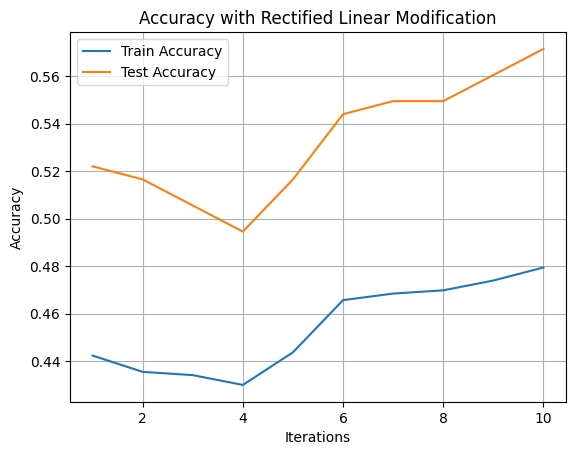

In [176]:
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy with Rectified Linear Modification")
plt.legend()
plt.grid(True)
plt.show()

Dropout Regularization Neuron Model Modification:

In [177]:
class Drop(nn.Module):
    def __init__(self, hidden_units, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(48*48, hidden_units)
        self.fc2     = nn.Linear(hidden_units, num_classes)
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x


model = Drop(hidden_units=64, num_classes=len(full_dataset.classes)).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_accuracies = []
test_accuracies = []
test_acc_dropout = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    train_acc = evaluate(model, train_loader)
    test_acc  = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    acc = evaluate(model, test_loader)
    test_acc_dropout.append(acc)
    
    print(f"Iteration {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Iteration 1/10 - Train Acc: 0.4478, Test Acc: 0.4835
Iteration 2/10 - Train Acc: 0.5082, Test Acc: 0.5989
Iteration 3/10 - Train Acc: 0.5742, Test Acc: 0.6593
Iteration 4/10 - Train Acc: 0.5934, Test Acc: 0.6868
Iteration 5/10 - Train Acc: 0.6415, Test Acc: 0.7198
Iteration 6/10 - Train Acc: 0.6319, Test Acc: 0.7088
Iteration 7/10 - Train Acc: 0.7170, Test Acc: 0.7692
Iteration 8/10 - Train Acc: 0.6978, Test Acc: 0.7473
Iteration 9/10 - Train Acc: 0.7198, Test Acc: 0.7692
Iteration 10/10 - Train Acc: 0.7349, Test Acc: 0.7747


In [178]:
accuracy = evaluate(model, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 77.47%


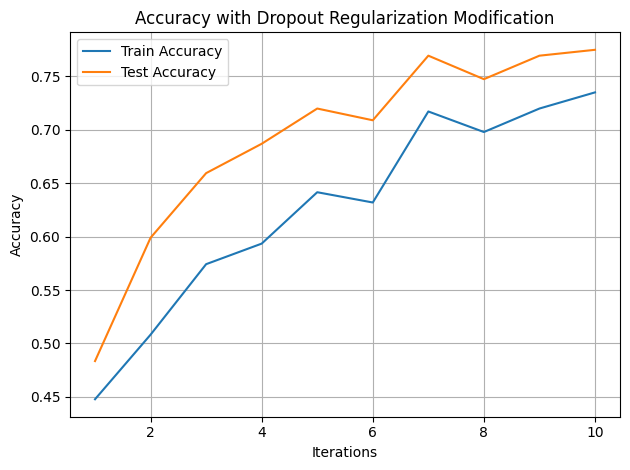

In [179]:
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy with Dropout Regularization Modification")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Adam Optimizer Neuron Model Modification:

In [180]:
model = RelU(hidden_units=64, num_classes=len(full_dataset.classes)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

train_accuracies = []
test_accuracies = []
test_acc_adam = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    train_acc = evaluate(model, train_loader)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    acc = evaluate(model, test_loader)
    test_acc_adam.append(acc)

    print(f"Iteration {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Iteration 1/10 - Train Acc: 0.6415, Test Acc: 0.7088
Iteration 2/10 - Train Acc: 0.8338, Test Acc: 0.8516
Iteration 3/10 - Train Acc: 0.8997, Test Acc: 0.9011
Iteration 4/10 - Train Acc: 0.9217, Test Acc: 0.8956
Iteration 5/10 - Train Acc: 0.9615, Test Acc: 0.9286
Iteration 6/10 - Train Acc: 0.9698, Test Acc: 0.9396
Iteration 7/10 - Train Acc: 0.9849, Test Acc: 0.9670
Iteration 8/10 - Train Acc: 0.9918, Test Acc: 0.9835
Iteration 9/10 - Train Acc: 0.9959, Test Acc: 0.9780
Iteration 10/10 - Train Acc: 0.9986, Test Acc: 0.9890


In [181]:
accuracy = evaluate(model, test_loader)
print(f"Accuracy after switching to Adam: {accuracy * 100:.2f}%")

Accuracy after switching to Adam: 98.90%


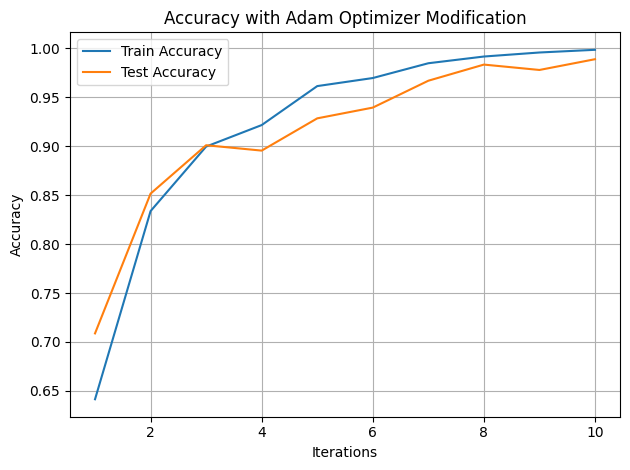

In [182]:
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy with Adam Optimizer Modification")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Hidden Layers Neuron Model Modification:

In [183]:
class Hid(nn.Module):
    def __init__(self, hidden_units, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(48*48, hidden_units)
        self.fc2     = nn.Linear(hidden_units, hidden_units) 
        self.fc3     = nn.Linear(hidden_units, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Hid(hidden_units=128, num_classes=len(full_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_accuracies = []
test_accuracies = []
test_acc_hidden = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc = evaluate(model, train_loader)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    acc = evaluate(model, test_loader)
    test_acc_hidden.append(acc)

    print(f"Iteration {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Iteration 1/10 - Train Acc: 0.2665, Test Acc: 0.2802
Iteration 2/10 - Train Acc: 0.4766, Test Acc: 0.5495
Iteration 3/10 - Train Acc: 0.4670, Test Acc: 0.5440
Iteration 4/10 - Train Acc: 0.4739, Test Acc: 0.5549
Iteration 5/10 - Train Acc: 0.4876, Test Acc: 0.5659
Iteration 6/10 - Train Acc: 0.4945, Test Acc: 0.5824
Iteration 7/10 - Train Acc: 0.4973, Test Acc: 0.5879
Iteration 8/10 - Train Acc: 0.5137, Test Acc: 0.6154
Iteration 9/10 - Train Acc: 0.5536, Test Acc: 0.6429
Iteration 10/10 - Train Acc: 0.5962, Test Acc: 0.6758


In [184]:
accuracy = evaluate(model, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 67.58%


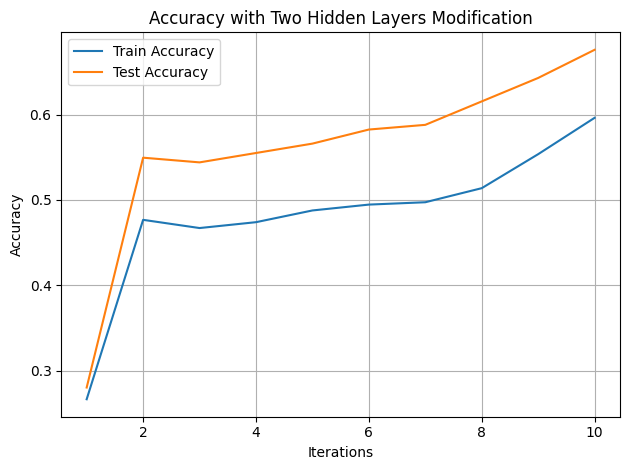

In [185]:
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy with Two Hidden Layers Modification")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Convolutional Neural Network Model Modification:

In [186]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

test_acc_cnn = []

def train_and_evaluate(model, train_loader, test_loader, num_epochs=10):
    train_accuracies = []
    test_accuracies = []

    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        
        train_accuracies.append(train_acc)
        
        test_accuracies.append(test_acc)

        acc = evaluate(model, test_loader)
        test_acc_cnn.append(acc)

        print(f"Iteration {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return train_accuracies, test_accuracies

model = CNN(num_classes=num_classes).to(device)
train_accuracies, test_accuracies = train_and_evaluate(model, train_loader, test_loader, num_epochs=10)


Iteration 1/10 - Train Acc: 0.6236, Test Acc: 0.6978
Iteration 2/10 - Train Acc: 0.7541, Test Acc: 0.7802
Iteration 3/10 - Train Acc: 0.9396, Test Acc: 0.9176
Iteration 4/10 - Train Acc: 0.9849, Test Acc: 0.9341
Iteration 5/10 - Train Acc: 0.9876, Test Acc: 0.9560
Iteration 6/10 - Train Acc: 0.9973, Test Acc: 0.9890
Iteration 7/10 - Train Acc: 0.9973, Test Acc: 0.9945
Iteration 8/10 - Train Acc: 0.9986, Test Acc: 0.9890
Iteration 9/10 - Train Acc: 0.9986, Test Acc: 0.9835
Iteration 10/10 - Train Acc: 1.0000, Test Acc: 1.0000


In [187]:
accuracy = evaluate(model, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


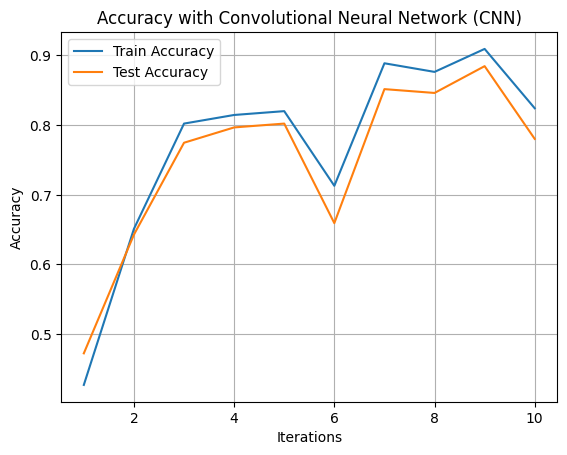

In [215]:
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Test Accuracy")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy with Convolutional Neural Network (CNN)')
plt.grid(True)
plt.legend()
plt.show()

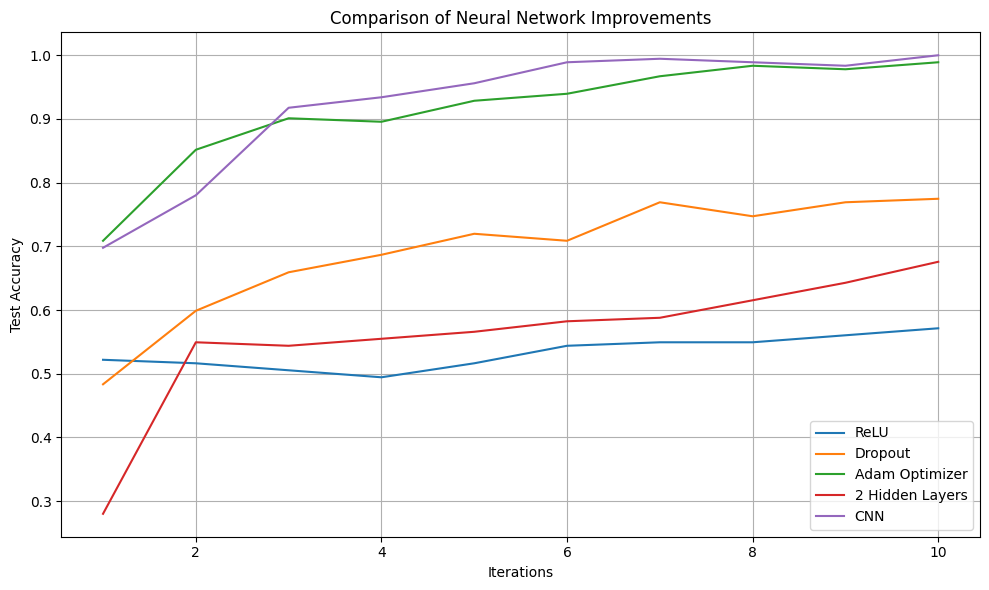

In [189]:
epochs = range(1, 11)

plt.figure(figsize=(10, 6))
plt.plot(epochs, test_acc_relu, label='ReLU')
plt.plot(epochs, test_acc_dropout, label='Dropout')
plt.plot(epochs, test_acc_adam, label='Adam Optimizer')
plt.plot(epochs, test_acc_hidden, label='2 Hidden Layers')
plt.plot(epochs, test_acc_cnn, label='CNN')

plt.xlabel("Iterations")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Neural Network Improvements")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Model Adaptations for Neurodivergent Conditions

Autism Neuron Model Modification:

In [190]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ASD(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout_configural = nn.Dropout2d(0.4)  
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_configural(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [191]:
def suppress(imgs, mode='ASD'):
    if mode == 'ASD':
        imgs = imgs.clone()
        _, _, h, _ = imgs.shape
        imgs[:, :, :h//3, :] *= 0.5   
        imgs[:, :, -h//3:, :] *= 0.5  
    return imgs

def fear_anger(labels, fear_idx, anger_idx, prob=0.3):
    new_labels = labels.clone()
    mask = (labels == fear_idx) & (torch.rand_like(labels.float()) < prob)
    new_labels[mask] = anger_idx
    return new_labels

In [192]:
def train(model, train_loader, test_loader, simulate_asd=False, fear_idx=4, anger_idx=0, num_epochs=10):
    train_accuracies = []
    test_accuracies = []
    test_acc_cnn = []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            if simulate_asd:
                imgs = suppress(imgs)
                labels = fear_anger(labels, fear_idx=fear_idx, anger_idx=anger_idx)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        test_acc_cnn.append(test_acc)

        print(f"Iteration {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return train_accuracies, test_accuracies


In [193]:
model = ASD(num_classes=num_classes).to(device)

train_accuracies, test_accuracies = train(
    model, train_loader, test_loader,
    simulate_asd=True, 
    fear_idx=4,        
    anger_idx=0,        
    num_epochs=10)

Iteration 1/10 - Train Acc: 0.5275, Test Acc: 0.5934
Iteration 2/10 - Train Acc: 0.5151, Test Acc: 0.5330
Iteration 3/10 - Train Acc: 0.7527, Test Acc: 0.7802
Iteration 4/10 - Train Acc: 0.7747, Test Acc: 0.7802
Iteration 5/10 - Train Acc: 0.8104, Test Acc: 0.7967
Iteration 6/10 - Train Acc: 0.8434, Test Acc: 0.8187
Iteration 7/10 - Train Acc: 0.8063, Test Acc: 0.7802
Iteration 8/10 - Train Acc: 0.8228, Test Acc: 0.7967
Iteration 9/10 - Train Acc: 0.9217, Test Acc: 0.8681
Iteration 10/10 - Train Acc: 0.8791, Test Acc: 0.8516


In [194]:
accuracy = evaluate(model, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.16%


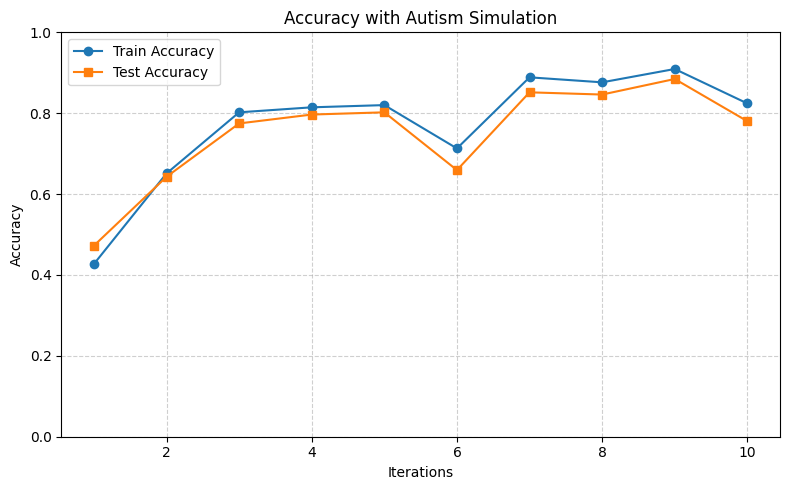

In [216]:
epochs = list(range(1, 11))
epochs = list(range(1, len(train_accuracies) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='s')
plt.title("Accuracy with Autism Simulation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Psychopathy Neuron Model Modification:

In [196]:
class Psycho(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout_configural = nn.Dropout2d(0.4) 
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  
        self.fc2 = nn.Linear(128, num_classes)

        self.emotion_loss_weights = torch.ones(num_classes, device='cuda' if torch.cuda.is_available() else 'cpu')

        if num_classes == 7:  
            self.emotion_loss_weights[3] = 1.5  
            self.emotion_loss_weights[2] = 1.5  
            self.emotion_loss_weights[4] = 1.5  

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_configural(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def custom_loss(self, outputs, labels):
        criterion = nn.CrossEntropyLoss(weight=self.emotion_loss_weights)
        return criterion(outputs, labels)

In [197]:
def suppress(imgs, mode='Psychopathy'):
    if mode == 'Psychopathy':
        imgs = imgs.clone()
        _, _, h, _ = imgs.shape
        imgs[:, :, :h//3, :] *= 0.5   
        imgs[:, :, -h//3:, :] *= 0.5  
    return imgs

def fear_anger(labels, fear_idx, anger_idx, prob=0.3):
    new_labels = labels.clone()
    mask = (labels == fear_idx) & (torch.rand_like(labels.float()) < prob)
    new_labels[mask] = anger_idx
    return new_labels

In [198]:
import torch.optim as optim

def train(model, train_loader, test_loader, simulate_psycho=False, sad_idx=3, happy_idx=2, fear_idx=4, num_epochs=10):
    train_accuracies = []
    test_accuracies = []
    test_acc_cnn = []

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            if simulate_psycho:
                imgs = suppress(imgs)
                labels = fear_anger(labels, fear_idx=fear_idx, anger_idx=0)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = model.custom_loss(outputs, labels)
            loss.backward()
            optimizer.step()

        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        test_acc_cnn.append(test_acc)

        print(f"Iteration {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return train_accuracies, test_accuracies

In [199]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [200]:
num_classes = 7  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Psycho(num_classes=num_classes).to(device)

train_accuracies, test_accuracies = train(
    model, train_loader, test_loader,
    simulate_psycho=True,  
    sad_idx=3,           
    happy_idx=2,            
    fear_idx=4,                
    num_epochs=10
)

Iteration 1/10 - Train Acc: 0.4973, Test Acc: 0.6154
Iteration 2/10 - Train Acc: 0.6223, Test Acc: 0.6978
Iteration 3/10 - Train Acc: 0.6868, Test Acc: 0.7143
Iteration 4/10 - Train Acc: 0.7294, Test Acc: 0.7582
Iteration 5/10 - Train Acc: 0.8283, Test Acc: 0.8132
Iteration 6/10 - Train Acc: 0.7692, Test Acc: 0.7802
Iteration 7/10 - Train Acc: 0.8338, Test Acc: 0.8462
Iteration 8/10 - Train Acc: 0.8846, Test Acc: 0.8901
Iteration 9/10 - Train Acc: 0.8668, Test Acc: 0.8571
Iteration 10/10 - Train Acc: 0.8970, Test Acc: 0.8681


In [201]:
accuracy = evaluate(model, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 86.81%


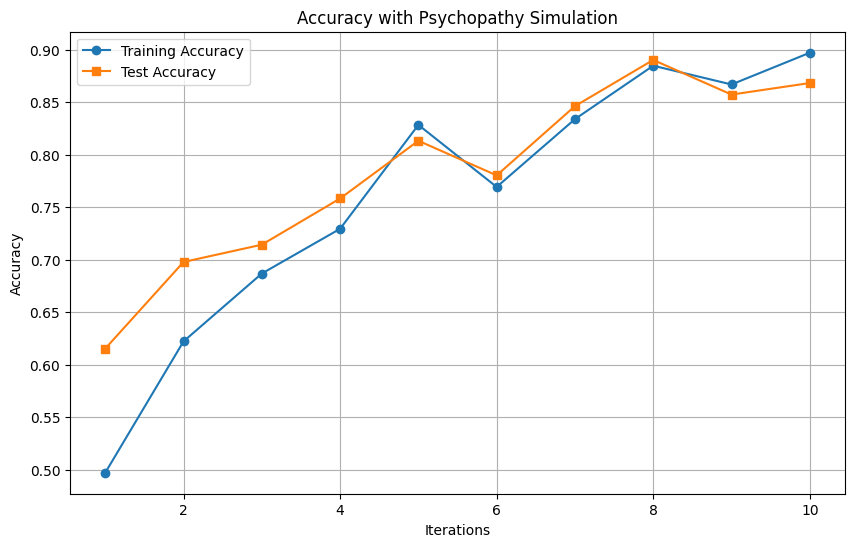

In [202]:
epochs = range(1, len(train_accuracies) + 1)
    
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='s')
plt.title('Accuracy with Psychopathy Simulation')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Alexithymia Neuron Model Modification:

In [204]:
class Alex(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout_configural = nn.Dropout2d(0.6)  
        self.dropout = nn.Dropout(0.5)  
        self.fc1 = nn.Linear(64 * 12 * 12, 128) 
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_configural(x)  
        x = torch.flatten(x, 1)
        x = self.dropout(x) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [205]:
def suppress(imgs, mode='alexithymia'):
    if mode == 'alexithymia':
        imgs = imgs.clone()
        _, _, h, _ = imgs.shape
        imgs[:, :, :h//3, :] *= 0.5  
        imgs[:, :, -h//3:, :] *= 0.5  
    return imgs

def emotions(labels, sadness_idx, fear_idx, prob=0.3):
    new_labels = labels.clone()
    mask = (labels == fear_idx) & (torch.rand_like(labels.float()) < prob)
    new_labels[mask] = sadness_idx
    return new_labels

In [206]:
def train(model, train_loader, test_loader, simulate_alex=False, sadness_idx=5, fear_idx=4, num_epochs=10):
    train_accuracies = []
    test_accuracies = []
    test_acc_cnn = []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            if simulate_alex:
                imgs = suppress(imgs)
                labels = emotions(labels, sadness_idx=sadness_idx, fear_idx=fear_idx)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        test_acc_cnn.append(test_acc)

        print(f"Iteration {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return train_accuracies, test_accuracies

In [207]:
model = Alex(num_classes=num_classes).to(device)

train_accuracies, test_accuracies = train(
    model, train_loader, test_loader,
    simulate_alex=True,  
    sadness_idx=5,            
    fear_idx=4,               
    num_epochs=10)

Iteration 1/10 - Train Acc: 0.4272, Test Acc: 0.4725
Iteration 2/10 - Train Acc: 0.6511, Test Acc: 0.6429
Iteration 3/10 - Train Acc: 0.8022, Test Acc: 0.7747
Iteration 4/10 - Train Acc: 0.8146, Test Acc: 0.7967
Iteration 5/10 - Train Acc: 0.8201, Test Acc: 0.8022
Iteration 6/10 - Train Acc: 0.7129, Test Acc: 0.6593
Iteration 7/10 - Train Acc: 0.8887, Test Acc: 0.8516
Iteration 8/10 - Train Acc: 0.8764, Test Acc: 0.8462
Iteration 9/10 - Train Acc: 0.9093, Test Acc: 0.8846
Iteration 10/10 - Train Acc: 0.8242, Test Acc: 0.7802


In [208]:
accuracy = evaluate(model, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.02%


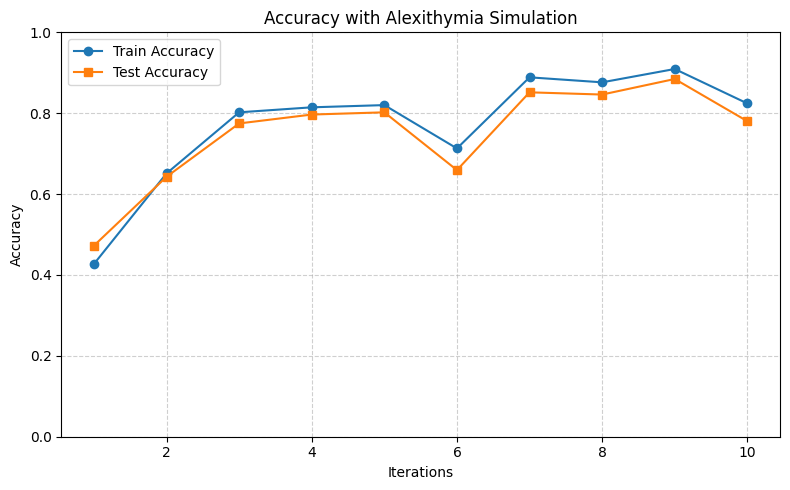

In [209]:
epochs = list(range(1, len(train_accuracies) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='s')
plt.title("Accuracy with Alexithymia Simulation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Performance Comparison of Baseline and Neurodivergent Cognitive Variants

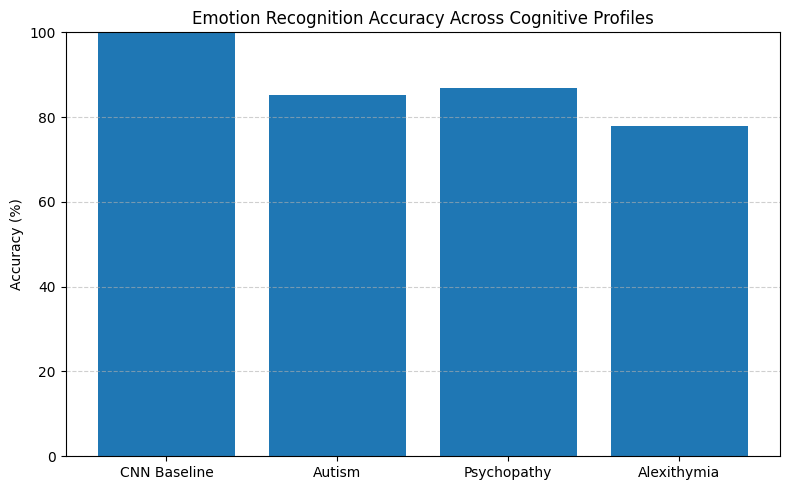

In [213]:
baseline_acc = 1.00
asd_acc = 0.8516
psychopathy_acc = 0.8681
alex_acc = 0.7802

variant_names = ["CNN Baseline", "Autism", "Psychopathy", "Alexithymia"]
variant_accs = [baseline_acc, asd_acc, psychopathy_acc, alex_acc]

plt.figure(figsize=(8, 5))
bars = plt.bar(variant_names, [a * 100 for a in variant_accs])
plt.ylabel("Accuracy (%)")
plt.title("Emotion Recognition Accuracy Across Cognitive Profiles")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()